<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/LayoutLMv3_KVP10k_ny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______

In [1]:
!pip install -q transformers datasets seqeval

In [2]:
!pip install evaluate


In [3]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer
from transformers import LayoutLMv3Processor
import torch
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/"
print(os.listdir(base_path))

['train', 'test']


In [6]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps = []
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps = sorted(overlaps)

  labeled = []
  for j, idx in enumerate(overlaps):
    tag = f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


#Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0 = max(box1[0], box2[0])
  y0 = max(box1[1], box2[1])
  x1 = min(box1[2], box2[2])
  y1 = min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word + bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels = ["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox = kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx] = tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box = kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx] = tag

  return labels

In [8]:
def load_example(doc_id, base_path):
  image_path = os.path.join(base_path, "images", f"{doc_id}.png")
  ocr_path = os.path.join(base_path, "ocrs", f"{doc_id}.json")
  gt_path = os.path.join(base_path, "gts", f"{doc_id}.json")

  image = Image.open(image_path).convert("RGB")

  with open(ocr_path, "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

  with open(gt_path, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

  page = ocr_data["pages"][0]
  width, height = page["width"], page["height"]

  words = [w["text"] for w in page["words"]]
  raw_boxes = [w["bbox"] for w in page["words"]]
  boxes = [normalize_bbox(b, width, height) for b in raw_boxes]

  kvps = gt_data["kvps_list"]
  string_labels = iob_from_kvps(words, raw_boxes, kvps)
  labels = [label_map[l] for l in string_labels]

  #Fyller på med padding, og truncation klipper av hvis sekvensen har for mange tokens, returnerer som PyTorch-tensor
  encoding = processor(image, words, boxes=boxes, word_labels=labels, padding="max_length", truncation=True, return_tensors="pt")

  return encoding, words, boxes, string_labels, image

In [35]:
from datasets import Dataset, DatasetDict, Image as HFImage
from tqdm import tqdm
import os

def load_split(split_name, base_path, limit=None):
    split_path = os.path.join(base_path, split_name)
    gts_dir = os.path.join(split_path, "gts")

    doc_ids = sorted([
        fname.replace(".json", "")
        for fname in os.listdir(gts_dir)
        if fname.endswith(".json")
    ])

    if limit:
        doc_ids = doc_ids[:limit]

    examples = []

    for doc_id in tqdm(doc_ids, desc=f"Laster {split_name}"):
        try:
            encoding, words, boxes, string_labels, image = load_example(doc_id, split_path)

            example = {
                "id": doc_id,
                "input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "bbox": encoding["bbox"].squeeze(0),
                "labels": encoding["labels"].squeeze(0),
                "pixel_values": encoding["pixel_values"].squeeze(0),
                "image": image,
                "tokens": words,
                "bboxes": boxes,
                "ner_tags": [label_map[l] for l in string_labels]

            }

            examples.append(example)

        except Exception as e:
            print(f"Feil i {doc_id}: {e}")

    #return Dataset.from_list(examples)
    return Dataset.from_list(examples).cast_column("image", HFImage(decode=True))


In [41]:
from copy import deepcopy

# Last inn begrenset antall dokumenter for utvikling/testing
raw_train_dataset = load_split("train", base_path, limit=10)
raw_test_dataset = load_split("test", base_path, limit=10)

# Kombiner i Hugging Face-format
dataset = DatasetDict({
    "train": deepcopy(raw_train_dataset),
    "test": deepcopy(raw_test_dataset),
})

# Angi hvilke kolonner som skal konverteres til PyTorch-tensorer
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "bbox", "labels", "pixel_values"],
)

# Splitt treningssettet i train + eval (f.eks. 80/20)
split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
eval_dataset = split["test"]

print("\n")
print(f"Fullt datasett: {dataset}")
print(f"Train: {train_dataset}")
print(f"Eval: {eval_dataset}")


Laster test: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]




Fullt datasett: DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
        num_rows: 10
    })
    test: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
        num_rows: 10
    })
})
Train: Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
    num_rows: 8
})
Eval: Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
    num_rows: 2
})


In [42]:
train_dataset.features

{'id': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'image': Image(mode=None, decode=True, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [43]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])
dict_keys(['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'])


In [13]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'<s> SYFY Frederick - 8148/8148 NE11335144 1 $18.00 TLC Montgomery Central Zone - NE11335144 2 $94.00 8449/8449 TVL Montgomery North Zone - NE11330248 6 $80.00 8450/8450 TVL Montgomery North Zone - NE11335144 3 $21.00 8450/8450 TWC Keyser WV - 8149/8149 NE11330248 3 $12.00 USA Cumberland - 8972/8972 NE11330248 2 $112.00 AMC Keyser WV - 8149/8149 NE11330248 1 $10.00 AMC Keyser WV - 8149/8149 NE11335144 2 $10.00 CNN Cumberland - 8972/8972 NE11330248 7 $292.00 CNN Frederick - 8148/8148 NE11335144 9 $562.00 DISC Frederick - 8148/8148 NE11330248 7 $610.00 ESP2 Cumberland - 8972/8972 NE11330248 2 $24.00 ESP2 Montgomery North Zone - NE11330248 2 $60.00 8450/8450 FBN Frederick - 8148/8148 NE11330248 8 $84.00 MASN Montgomery North Zone - NE11335144 $38.00 8450/8450 MNBC Cumberland - 8972/8972 NE11330248 10 $412.00 MNBC Cumberland - 8972/8972 NE11335144 4 $48.00 MNBC Montgomery North Zone - NE11330248 21 $2,888.00 8450/8450 MNBC Montgomery North Zone - NE11335144 48 $2,952.00 8450/8450 SYFY Mont

In [14]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 SY 0
FY -100
 Frederick 0
 - 0
 8 0
148 -100
/ -100
8 -100
148 -100
 NE 0
11 -100
335 -100
144 -100
 1 0
 $ 0
18 -100
. -100
00 -100
 T 0
LC -100
 Montgomery 0
 Central 0
 Zone 0
 - 0
 NE 0
11 -100
335 -100
144 -100
 2 0
 $ 0
94 -100
. -100
00 -100
 8 0
449 -100
/ -100
8 -100
449 -100
 TV 0
L -100
 Montgomery 0
 North 0
 Zone 0
 - 0
 NE 0
113 -100
30 -100
248 -100
 6 0
 $ 0
80 -100
. -100
00 -100
 84 0
50 -100
/ -100
84 -100
50 -100
 TV 0
L -100
 Montgomery 0
 North 0
 Zone 0
 - 0
 NE 0
11 -100
335 -100
144 -100
 3 0
 $ 0
21 -100
. -100
00 -100
 84 0
50 -100
/ -100
84 -100
50 -100
 TW 0
C -100
 Keys 0
er -100
 W 0
V -100
 - 0
 8 0
149 -100
/ -100
8 -100
149 -100
 NE 0
113 -100
30 -100
248 -100
 3 0
 $ 0
12 -100
. -100
00 -100
 USA 0
 Cumber 0
land -100
 - 0
 89 0
72 -100
/ -100
89 -100
72 -100
 NE 0
113 -100
30 -100
248 -100
 2 0
 $ 0
112 -100
. -100
00 -100
 AMC 0
 Keys 0
er -100
 W 0
V -100
 - 0
 8 0
149 -100
/ -100
8 -100
149 -100
 NE 0
113 -100
30 -100
248 -100
 1 0
 $ 0


In [15]:
from evaluate import load
metric = load("seqeval")

In [16]:
import numpy as np

label_list = ["O", "B-KEY", "I-KEY", "B-VALUE", "I-VALUE"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [17]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

train_args = TrainingArguments(
    output_dir="test",  # Modell og checkpoints
    #max_steps=1000,
    num_train_epochs=5,     # <- i stedet for max_steps når man bruker A100
    per_device_train_batch_size=8, #2 - 8
    per_device_eval_batch_size=8, # 2 - 8
    learning_rate=1e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=125, #eval per epoche (når vi bruker 1000 docs)
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",         # 👈 Viktig for TensorBoard
    logging_steps=50,             # Hvor ofte den logger
    report_to="tensorboard"       # 👈 Skrur på TensorBoard logging
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
from transformers import Trainer, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator

trainer = Trainer (
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-19-a9ae2afda081>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (


In [20]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=50, training_loss=0.8535921478271484, metrics={'train_runtime': 27.653, 'train_samples_per_second': 14.284, 'train_steps_per_second': 1.808, 'total_flos': 104122244305920.0, 'train_loss': 0.8535921478271484, 'epoch': 5.0})

In [21]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 1.2675364017486572,
 'eval_precision': 0.23770491803278687,
 'eval_recall': 0.043348281016442454,
 'eval_f1': 0.07332490518331226,
 'eval_accuracy': 0.578135949544499,
 'eval_runtime': 0.7841,
 'eval_samples_per_second': 25.506,
 'eval_steps_per_second': 3.826,
 'epoch': 5.0}

In [45]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")


In [49]:
example = dataset["test"][0]
print(example.keys())
example_raw = raw_test_dataset[0]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'])


In [50]:
for k, v in example.items():
  print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [51]:
# Pakker ut tensorene
inputs = {
    "input_ids": example["input_ids"].unsqueeze(0),
    "attention_mask": example["attention_mask"].unsqueeze(0),
    "bbox": example["bbox"].unsqueeze(0),
    "pixel_values": example["pixel_values"].unsqueeze(0)
}

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [53]:
# Inference
with torch.no_grad():
    outputs = model(**inputs)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [54]:
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = example["labels"]

In [55]:
print(predictions)

[0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 3, 4, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 3, 4, 4, 4, 4, 4, 4, 1, 2, 2, 3, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 3, 0, 4, 4, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 

In [56]:
print(f"{'Token ID':10} {'Label':10} {'Pred':10}")
print("=" * 30)
for token_id, label_id, pred_id in zip(example["input_ids"], labels, predictions):
    if label_id == -100:
        continue
    token = processor.tokenizer.decode([token_id])
    print(f"{token:10} {id2label[label_id.item()]:10} {id2label[pred_id]:10}")

Token ID   Label      Pred      
 Arkansas  O          B-KEY     
 P         O          I-KEY     
 Arkansas  O          B-KEY     
 Honey     O          I-KEY     
 Pe        O          B-KEY     
 Butter    O          I-KEY     
 16        B-KEY      B-VALUE   
 oz        I-KEY      I-VALUE   
 Date      B-KEY      B-KEY     
 Name      B-KEY      B-KEY     
 Email     B-KEY      B-KEY     
 address   I-KEY      I-KEY     
 Phone     B-KEY      B-KEY     
 Campus    B-KEY      B-KEY     
 Delivery  I-KEY      I-KEY     
 Address   I-KEY      I-KEY     
 (         I-KEY      I-KEY     
 only      I-KEY      I-KEY     
 Which     B-KEY      B-KEY     
 club      I-KEY      I-KEY     
 member    I-KEY      I-KEY     
 sold      I-KEY      I-KEY     
 to        I-KEY      I-KEY     
 you       I-KEY      I-KEY     
 Comments  B-KEY      B-KEY     
 Order     O          O         
 Pick      O          O         
 Information O          O         
 When      O          B-KEY     
 Wednesd

In [31]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [63]:
image = example_raw["image"].copy().convert("RGB")  # PIL image
token_boxes = example["bbox"]  # allerede ferdig prosessert
labels = example["labels"]
input_ids = example["input_ids"]

# Unnormalize bboxes
width, height = image.size
true_boxes = [
    unnormalize_box(box, width, height)
    for box, label in zip(token_boxes, labels)
    if label != -100
]


# Konverter til tekst og fjern -100 padding
true_predictions = [
    id2label[int(pred)] for pred, label in zip(predictions, labels) if label != -100
]
true_labels = [
    id2label[int(label)] for pred, label in zip(predictions, labels) if label != -100
]

token_boxes = example["bbox"]
width, height = example_raw["image"].size

true_boxes = [
    unnormalize_box(box, width, height)
    for box, label in zip(token_boxes, labels)
    if label != -100
]

In [64]:
def iob_to_label(label):
    if label.startswith("B-") or label.startswith("I-"):
        return label[2:].lower()
    return "other"

label2color = {
    "key": "blue",
    "value": "green",
    "other": "gray"
}

Models predictions

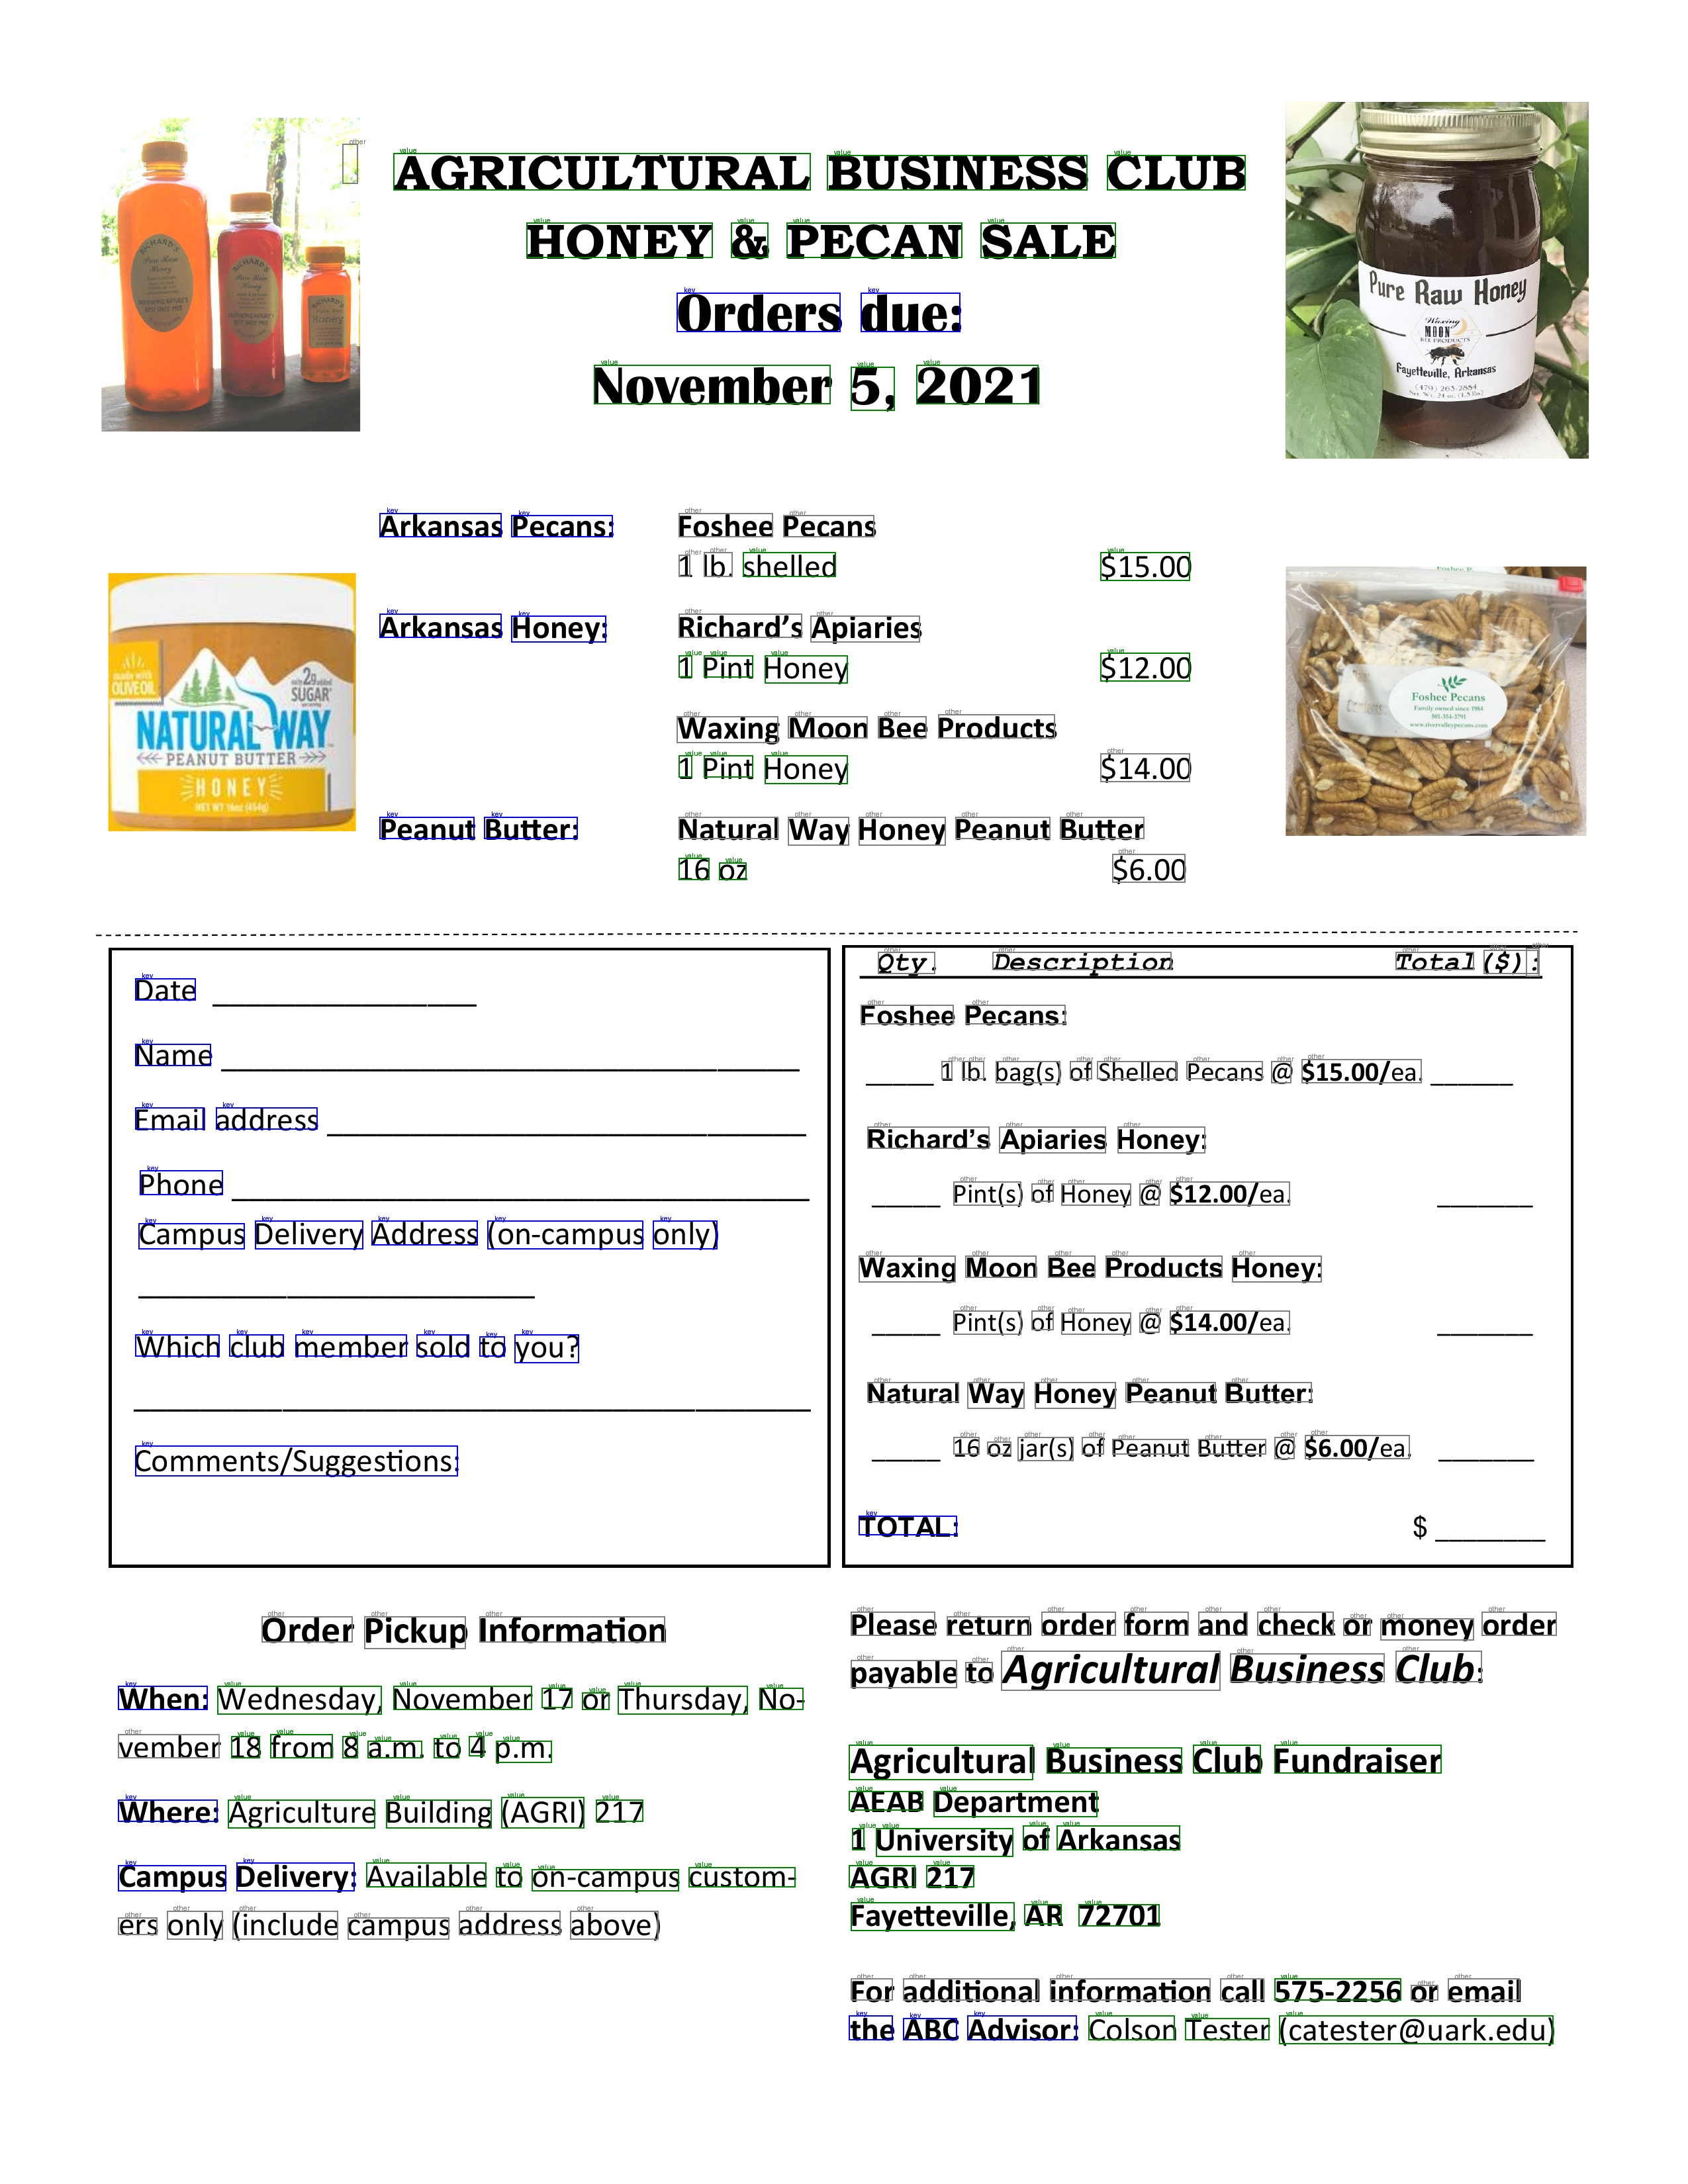

In [66]:
from PIL import ImageDraw, ImageFont
from IPython.display import display

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for pred_label, box in zip(true_predictions, true_boxes):
    label = iob_to_label(pred_label)
    draw.rectangle(box, outline=label2color.get(label, "red"), width=2)
    draw.text((box[0] + 10, box[1] - 10), label, fill=label2color.get(label, "red"), font=font)

display(image)


_______
Ground truth

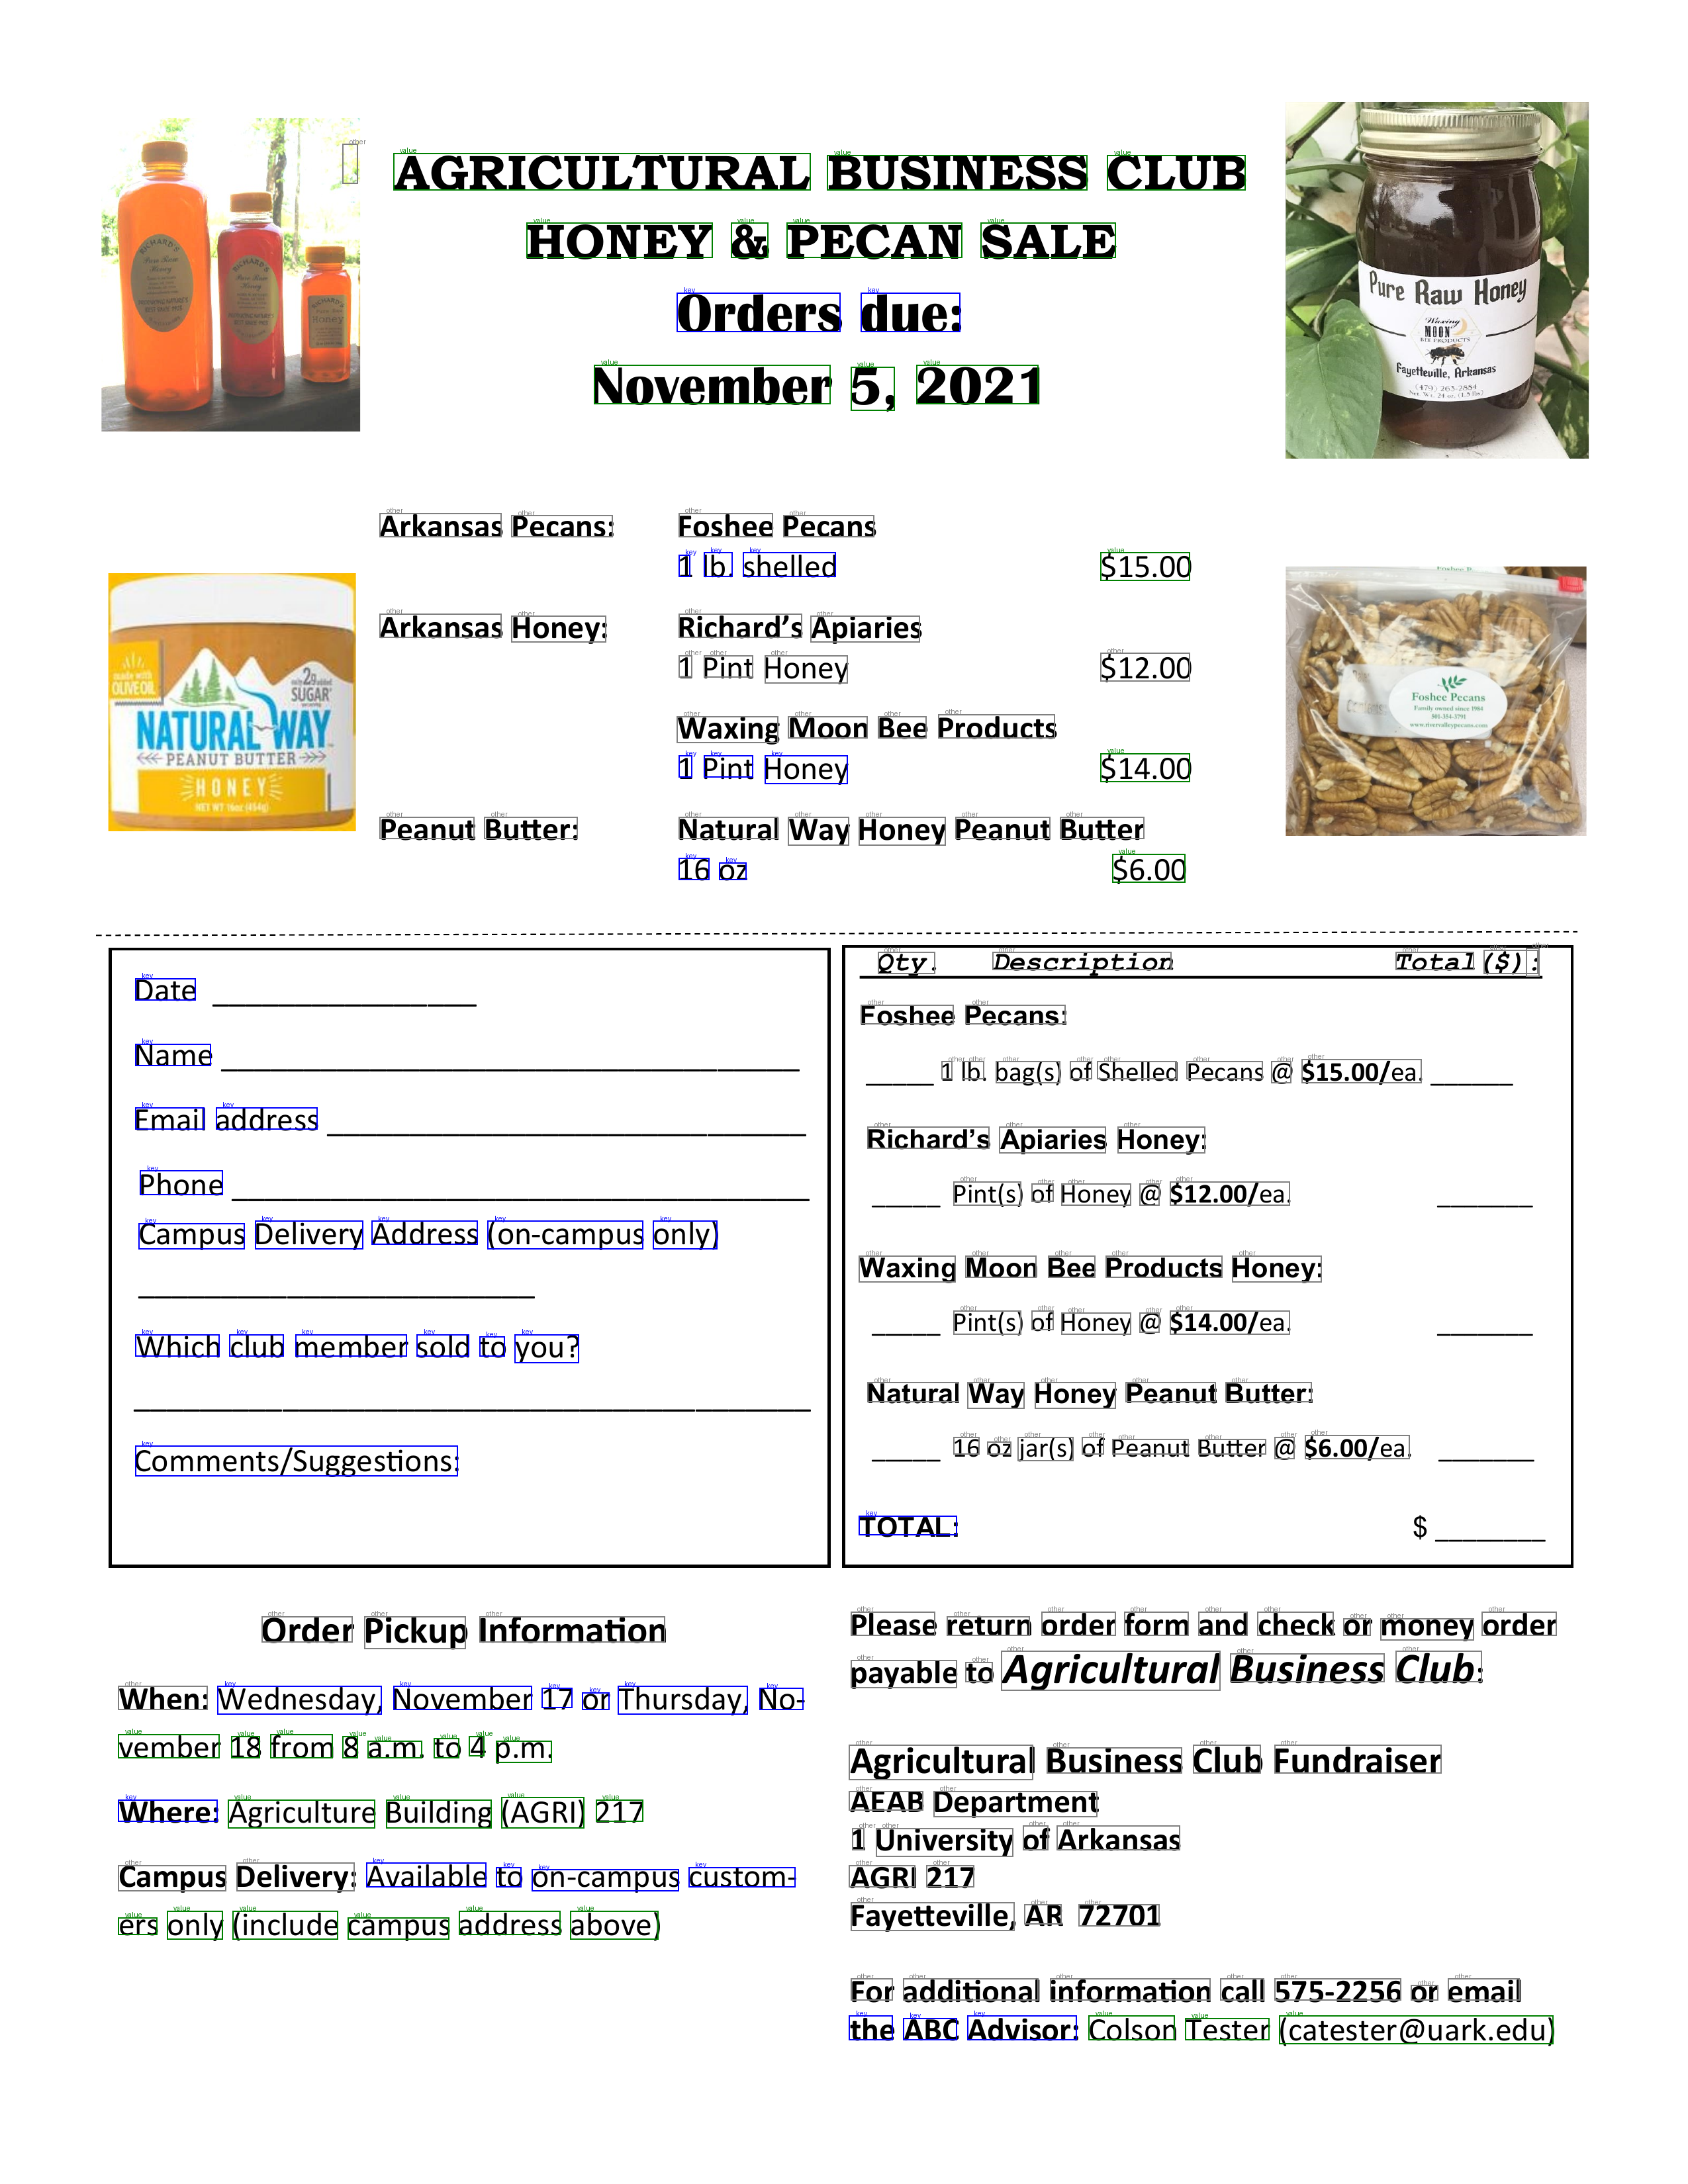

In [68]:
image_true = example_raw["image"].convert("RGB")
draw_true = ImageDraw.Draw(image_true)

for word, box, label_id in zip(example_raw['tokens'], example_raw['bboxes'], example_raw['ner_tags']):
    label = iob_to_label(id2label[label_id]).lower()
    box = unnormalize_box(box, width, height)
    draw_true.rectangle(box, outline=label2color.get(label, "gray"), width=2)
    draw_true.text((box[0] + 10, box[1] - 10), label, fill=label2color.get(label, "gray"), font=font)

display(image_true)
